In [ ]:
!pip install langchain langchain_core langchain_groq langchain_community langchain langgraph

In [ ]:
import os
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph , END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate

In [ ]:
from langchain_groq import ChatGroq
from google.colab import userdata

In [ ]:
llm=ChatGroq(
    temperature=0,
    groq_api_key=userdata.get('Groq'),
    model_name="qwen/qwen3-32b",
    verbose=True
)

In [ ]:
llm.invoke("hi").content

'<think>\nOkay, the user said "hi". That\'s a greeting. I should respond in a friendly and welcoming way. Maybe ask how I can assist them. Keep it open-ended so they can specify what they need help with. Let me make sure the tone is positive and approachable.\n</think>\n\nHello! How can I assist you today? 😊'

AGENTIC WORKFLOW

Inputs

1.Mood (thriller, feel-good, mystery)

2.Genre Preference

3.language

4.Platform (Netflix, Prime, etc.)

Output

In [ ]:
class Movie(TypedDict):
  messages: Annotated[list[HumanMessage|AIMessage],"the message in the conversation"]
  Mood:str
  Genre:str
  Language:str
  Platform:str

In [ ]:
def mood(state:Movie):
  print("Please enter your mood (thriller, feel-good, mystery)")
  state["Mood"]=input()
  state["messages"]=state["messages"]+[HumanMessage(content=f"Your mood is {state['Mood']}")]
  return state


def genre(state:Movie):
  print("Please enter your prefered Genre. Such as Action, Drama, Comedy, Thriller, Sci-Fi, Romance")
  user=input()
  state["Genre"]=[genre.strip() for genre in user.split(",")]
  state["messages"]=state["messages"]+[HumanMessage(content=f"Your favourite genre are :{state["Genre"]}")]

  return state

def language(state:Movie):
  print("Please enter your preferred Language")
  state["Language"]=input()
  state["messages"]=state["messages"]+[HumanMessage(content=f"Your prefered language is:{state["Language"]}")]
  return state

In [ ]:
def platform(state:Movie):
  print("Please enter your preferred platform")
  state["Platform"]=input()
  state["messages"]=state["messages"]+[HumanMessage(content=f"Your prefered platform is:{state["Platform"]}")]
  return state

In [ ]:
# def suggestion(state:Movie):
#   print(f"Here is the suggestion for you with {state['Mood']}, {state['Genre']}, {state['Language']}, {state['Platform']}")
#   movie_recommendation_prompt = ChatPromptTemplate.from_messages([
#     (
#         "system",
#         "You are an intelligent movie recommendation agent. "
#         f"Based on the user's mood: {state['Mood']}, preferred genre: {state['Genre']}, "
#         f"language: {state['Language']}, and available streaming platform: {state['Platform']}, "
#         "recommend suitable movies. "
#         "Provide 2–3 concise recommendations with a short reason for each choice."
#     ),
#     (
#         "human",
#         "Suggest movies for me to watch."
#     ),
#     ])

#   response=llm.invoke(movie_recommendation_prompt)
#   print(response.content)
#   state["messages"]=state["messages"]+[AIMessage(content=response.content)]
#   return state

In [ ]:
def suggestion(state: Movie):
    print(f"\nGenerating suggestions for you with:")
    print(f"  Mood: {state['Mood']}")
    print(f"  Genre: {state['Genre']}")
    print(f"  Language: {state['Language']}")
    print(f"  Platform: {state['Platform']}\n")

    # Create the prompt with actual state values
    movie_recommendation_prompt = ChatPromptTemplate.from_messages([
        ("system",
         f"You are an intelligent movie recommendation agent. "
         f"Based on the user's mood: {state['Mood']}, preferred genres: {', '.join(state['Genre'])}, "
         f"language: {state['Language']}, and available streaming platform: {state['Platform']}, "
         f"recommend suitable movies. "
         f"Provide 2–3 concise recommendations with a short reason for each choice."),
        ("human", "Suggest movies for me to watch.")
    ])
    # Fixed: Format the template into messages before invoking
    prompt = movie_recommendation_prompt.format_messages()

    response = llm.invoke(prompt)
    print(response.content)
    state["messages"] = state["messages"] + [AIMessage(content=response.content)]
    return state  # Fixed: added return statement

In [ ]:
workflow=StateGraph(Movie)

In [ ]:
workflow.add_node("input_mood", mood)
workflow.add_node("input_genre", genre)
workflow.add_node("input_language", language)
workflow.add_node("input_platform", platform)
workflow.add_node("suggestion", suggestion)

In [ ]:
workflow.add_edge("input_mood", "input_genre")
workflow.add_edge("input_genre", "input_language")
workflow.add_edge("input_language", "input_platform")
workflow.add_edge("input_platform", "suggestion")

In [ ]:
from langgraph.graph import START, END
workflow.add_edge(START,"input_mood")
workflow.add_edge("suggestion",END,)

In [ ]:
app = workflow.compile()

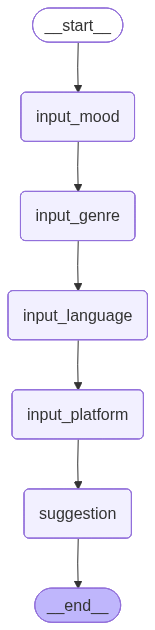

In [ ]:
app

In [ ]:
def Agent(user_request: str):
  print(f"Initial Request: {user_request}\n")
  state = {
      "messages": [HumanMessage(content=user_request)],
      "Mood": "",
      "Genre": [],
      "Language": "",
      "Platform":"",
  }
  for output in app.stream(state):
    pass

In [ ]:
user_request="I want to watch a movie"
Agent(user_request)

Initial Request: I want to watch a movie

Please enter your mood (thriller, feel-good, mystery)
feel-goog
Please enter your prefered Genre. Such as Action, Drama, Comedy, Thriller, Sci-Fi, Romance
Drama
Please enter your preferred Language
English
Please enter your preferred platform
Netflix

Generating suggestions for you with:
  Mood: feel-goog
  Genre: ['Drama']
  Language: English
  Platform: Netflix

<think>
Okay, the user wants movie recommendations. Let me check the details they provided. Their mood is "feel-good," so they probably want uplifting or positive stories. Preferred genres are Drama, so I should focus on dramas that are also feel-good. The language is English, and they want movies available on Netflix.

First, I need to think of feel-good dramas on Netflix. "The Pursuit of Happyness" comes to mind. It's a true story about perseverance and overcoming adversity, which fits the feel-good and drama categories. It's also a classic that's likely on Netflix.

Next, "To All t